In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:

# Import des librairies
from fastai.vision.all import *
from fastai.vision.widgets import *

In [7]:
# # On importe le dataset et on le dezippe
from zipfile import ZipFile
file_name ='/content/intel.zip' # dossier comprenant 130 dossiers correspondant à chaque race
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('OK')

OK


In [13]:
DATASET_PATH = Path('/content/intel/data/train')

In [14]:
DATASET_PATH.ls()

(#6) [Path('/content/intel/data/train/forest'),Path('/content/intel/data/train/buildings'),Path('/content/intel/data/train/sea'),Path('/content/intel/data/train/mountain'),Path('/content/intel/data/train/street'),Path('/content/intel/data/train/glacier')]

In [16]:
(DATASET_PATH/'sea').ls()

(#2274) [Path('/content/intel/data/train/sea/136.jpg'),Path('/content/intel/data/train/sea/8402.jpg'),Path('/content/intel/data/train/sea/1447.jpg'),Path('/content/intel/data/train/sea/15463.jpg'),Path('/content/intel/data/train/sea/4790.jpg'),Path('/content/intel/data/train/sea/13484.jpg'),Path('/content/intel/data/train/sea/4874.jpg'),Path('/content/intel/data/train/sea/11503.jpg'),Path('/content/intel/data/train/sea/8473.jpg'),Path('/content/intel/data/train/sea/9573.jpg')...]

In [17]:
# Creation du train et test set On applique des transformations uniquement au train set
intel_datablock= DataBlock(blocks= (ImageBlock, CategoryBlock),
                           get_items= get_image_files,
                           splitter= RandomSplitter(valid_pct= 0.2, seed=76),
                           get_y = parent_label,
                           item_tfms= RandomResizedCrop(224, min_scale=0.3), #
                           batch_tfms= aug_transforms(mult=2))

In [18]:
#Charger le train et test set
data= intel_datablock.dataloaders(DATASET_PATH)

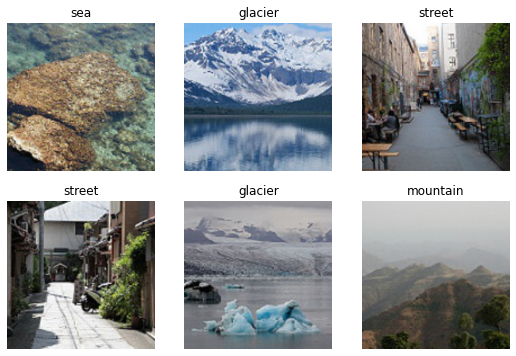

In [19]:
# Visualisation d'images
data.valid.show_batch(max_n= 6, nrows=2)

In [20]:
# Import du resau de neurones resnet34 pour le transfer learning
learn= cnn_learner(data, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [21]:
intel_datablock.summary(DATASET_PATH)

Setting-up type transforms pipelines
Found 14034 items
2 datasets of sizes 11228,2806
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/intel/data/train/street/12430.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=150x150
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/intel/data/train/street/12430.jpg
    applying parent_label gives
      street
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(5)

Final sample: (PILImage mode=RGB size=150x150, TensorCategory(5))


Found 14034 items
2 datasets of sizes 11228,2806
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Rand

In [22]:
# Entrainnement sur 4 epoch (le taux d'erreur est de 8%)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.731868,0.313527,0.104063,01:08
1,0.487697,0.268428,0.090877,01:10
2,0.394780,0.242706,0.087669,01:11
3,0.353676,0.234879,0.084818,01:12


In [23]:

# On obtient un modele avec un taux d'erreur d'environ 8%. On sauvegarde le modele
learn.save('model-1')

Path('models/model-1.pth')

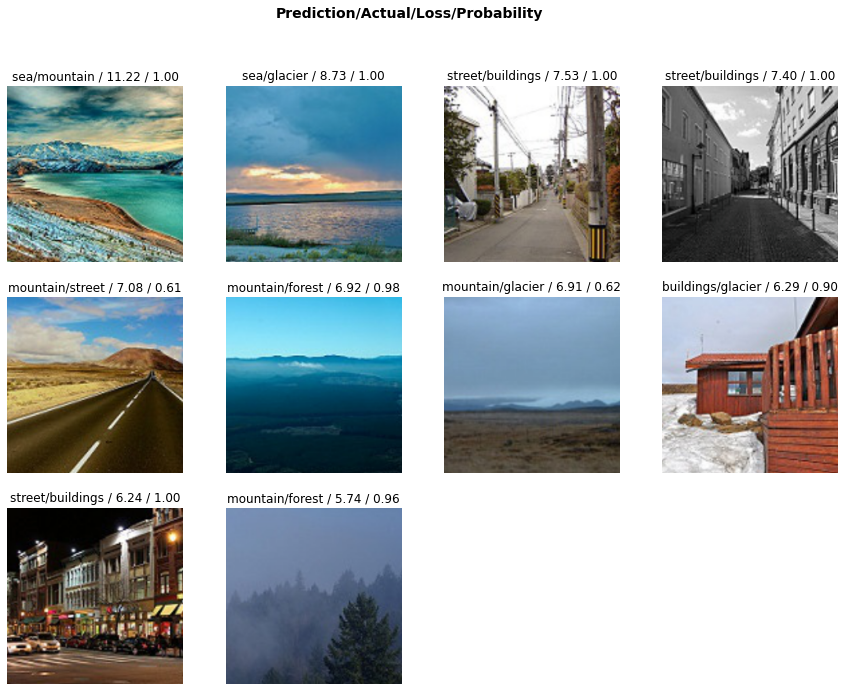

In [24]:

#Interpretation du modele et visualisation de 9 images ou il y a eu le plus de confusion entre les races
interp= ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(10, figsize=(15,11))

In [25]:
# Liste des categories ou il y a eu au moins 3 confusions
interp.most_confused(min_val=3)

[('mountain', 'glacier', 50),
 ('glacier', 'mountain', 49),
 ('street', 'buildings', 45),
 ('buildings', 'street', 31),
 ('glacier', 'sea', 16),
 ('mountain', 'sea', 10),
 ('sea', 'glacier', 6),
 ('sea', 'mountain', 6),
 ('forest', 'mountain', 4),
 ('glacier', 'buildings', 3),
 ('glacier', 'forest', 3)]

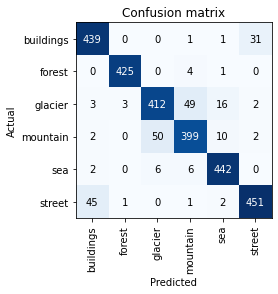

In [27]:
# Matrice de confusion
interp.plot_confusion_matrix()

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=1.3182567499825382e-06)

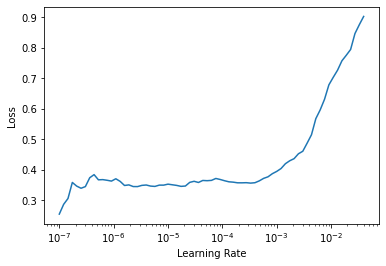

In [28]:
# On unfreeze le modele
learn.unfreeze()
# Detection du bon learning rate
learn.lr_find()

In [30]:
# Entrainement sur nouveau learning rate
learn.unfreeze()
learn.fit_one_cycle(4, lr_max= slice(1.5e-07,1.5e-06), )  

epoch,train_loss,valid_loss,error_rate,time
0,0.352959,0.234997,0.085175,01:33
1,0.358531,0.236650,0.082680,01:36
2,0.353365,0.241144,0.083393,01:38
3,0.335694,0.238787,0.082680,01:38


In [31]:
# On obtient un modele avec un taux d'erreur d'environ 8%. On sauvegarde le modele
learn.save('model-2')

Path('models/model-2.pth')

In [32]:
#Export en pkl
learn.export()

In [33]:

# Test
learn_inf = load_learner('export.pkl')
# Prediction d'une image d'un building
learn_inf.predict('/content/intel/data/test/buildings/20073.jpg')

('buildings',
 tensor(0),
 tensor([9.9674e-01, 7.9684e-06, 1.0388e-04, 4.3646e-04, 2.0279e-03, 6.8037e-04]))

In [35]:
learn_inf.dls.vocab

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [37]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description = 'Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred, pred_idx, probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction : {pred} ; Probability: {probs[pred_idx]: .04f}'

btn_run.on_click(on_click_classify)

In [38]:
VBox([widgets.Label('Select your picture'), btn_upload, btn_run, out_pl, lbl_pred])